questionable of me to name this notebook as if it's the kid-friendly version of my new rap album but this is the less messy, more organized, better documented version that I'd recommend for anyone using this code in the future. My train wreck version is just make_file_lists, I'll probably include that one too just in case the solution to any future problems is buried in that mess, but. This is the friendly one use this one

In [1]:
#import stuff. way too much stuff, I keep not bothering to take out the ones that weren't actually used in the final version, sorry,
import csv
import glob
from astropy.io import fits
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import sys
import random
import datetime
import traceback
from tqdm import tqdm
import pandas as pd

### define functions

In [2]:
def fits_to_tiff(filepath, img_type, r=False, outp_name=None, absval=False, log_10=True):
    '''Does the conversion from .fits data to .tiff images, saves .tiff files under new name and directory. 
    Inputs: filepath (string, full path to the file ie '/home/zenalisa/data/dataset_name/AR_number/filename.fits' )
            img_type (string, either 'aia' or 'hmi'. Have to specify because they need slightly different preprocessing steps before converting to a uint8 image)
            r (bool flag that controls whether or not to rotate the data- leftover from when I randomly rotated the training data by either 0 or 180 degrees to artificially remove any hemisphere bias, should be able to leave as False. If you did want to rotate, you'd want to randomly set r=True half the time you call this function, and be sure to have the same random flag for both the AIA and corresponding HMI image.)
            outp_name (string, new output directory for .tiff files. If left as default, will add /tiff just before the AR number in filepath argument to make a new directory and save there. ie if the original fits location is '/home/zenalisa/data/dataset_name/AR_number/file_name.fits', default output location is '/home/zenalisa/data/dataset_name/tiff', and new file will save as '/home/zenalisa/data/dataset_name/tiff/AR_number/file_name.tiff'. I didn't use the default often, preferred to specify my own new output spot, but kept it so I never accidentally mixed the tiff files in with the fits.)
            absval (bool flag controls whether or not to take absolute value of HMI data. Less relevant now/ should stay False since we're doing this for signed magnetograms, but I'll leave it in case anybody ever wants to use it.)
            log_10 (bool flag that controls whether or not to take log10 of AIA data. Can probably be left as True, but again I'll leave the option just in case.)
    Outputs: string name of new .tiff file, min data value, max data value.
    Notes: Current version doesn't do any clipping to AIA data before converting to uint8, just scales each image according to its own min and max values. I wrote more on why that's not the best way to do this and why I did it anyway in the thesis, but it's something to be aware of (and fix, in my opinion) if you're improving on this process in the future. I added some notes in the readme too on some weird technical difficulties that popped up when I did try the AIA clipping, highly recommend taking a peek at that if you're tackling the clipping problem, might spare you from the multiple days of NaN hunting that I suffered through.'''

    name, ext = os.path.splitext(filepath)
    
    if not outp_name:
        outp_name = name.replace(name.split('/')[-2], name.split('/')[-2]+'/tiff') #places new files in separate directory
    
    img = fits.open(filepath)
    img.verify('fix')

    #img.info()

    data = img[1].data #has to be img[1]
    
    if r:
        data=np.rot90(data)
        data=np.rot90(data)
    
    width = data.shape[1]
    height = data.shape[0]
    
    #aia_max=2550 
    #aia_min=1 #helps with log yelling at me
    hmi_offset=2550
    
    if img_type == 'aia':
        
        if log_10:
            data = np.log10(data - np.amin(data))
        else:
            data=data-np.amin(data)
        
        data=data.astype(float)/np.amax(data)*255
        data=np.round(data)
        data=data.astype(np.uint8)
    
            
        
    elif img_type == 'hmi':
        if absval:
            data = abs(data)
        
        data[data>hmi_offset]=hmi_offset
        data[data<-hmi_offset]=-hmi_offset
        data=data+hmi_offset
        data=data*255./(2*hmi_offset)
        data=np.round(data)
        data=data.astype(np.uint8)
        
    outputArray = np.array(data, dtype=np.uint8)

    output = Image.fromarray(outputArray.reshape((height, width)), "L")

    if not os.path.exists(outp_name + '/' +  name.split('/')[-2]):
        os.makedirs(outp_name + '/' +  name.split('/')[-2])
    
    output.save(outp_name + '/' +  name.split('/')[-2]+ '/'+ name.split('/')[-1]+".tiff")
    img.close()
    
    return(outp_name + '/' +  name.split('/')[-2]+ '/'+ name.split('/')[-1]+".tiff", data.min(), data.max())



In [3]:
def timestamp(filename):
    '''extracts timestamp, for sorting files by timestamp. used as 'key' argument in regular degular python sort() function
    Input: string filename
    Output: timestamp part of filename (also a string)'''
    t = filename.split('/')[-1].split('.')[2]
    return t

In [4]:
def timediff(file1, file2):
    '''calculates difference in timestamps between two files. Used to make sure HMI and AIA files are close enough in time (within 720 seconds) to be an image pair.
    Inputs: file1 and file2, paths to the fiels you want to compare. Doesn't matter which order you pass these in (file1=hmi, file2=aia or vice versa), try/except part of this function covers it both ways
    Outputs: the absolute difference in seconds between the two files' timestamps.'''
    
    try:
        file1_time = file1.split('/')[-1].split('.')[2].split('Z')[0]
        file1_time = datetime.datetime.strptime(file1_time, '%Y-%m-%dT%H%M%S')
    except ValueError:
        file1_time = file1.split('/')[-1].split('.')[2].split('TAI')[0]
        file1_time = datetime.datetime.strptime(file1_time, '%Y%m%d_%H%M%S_')
        
    try:
        file2_time = file2.split('/')[-1].split('.')[2].split('Z')[0]
        file2_time = datetime.datetime.strptime(file2_time, '%Y-%m-%dT%H%M%S')
    except ValueError:
        file2_time = file2.split('/')[-1].split('.')[2].split('TAI')[0]
        file2_time = datetime.datetime.strptime(file2_time, '%Y%m%d_%H%M%S_')
    

    return abs(file1_time - file2_time)
    

In [5]:
def which_hem(fname, srs):
    '''finds which hemisphere an active region formed in by finding and reading the AR's SRS (solar region summary) file. 
    Inputs: fname, string, path to the first image in the active region's directory
    Outputs: h, string, 'N' if north hemisphere, 'S' if south.'''
    
    simple_date=fname.split('.')[-4].split('_')[0]
    date=datetime.datetime.strptime(simple_date, '%Y%m%d')
    srs_file=srs+str(date.year)+'_SRS/'+str(simple_date)+'SRS.txt'

    srs_file=open(srs_file, 'r')
    lines=srs_file.readlines()
    for l in lines:
        if 'I.  Regions with Sunspots.' in l:
            start=lines.index(l)
        if 'IA. H-alpha Plages without Spots.' in l:
            stop=lines.index(l)
            break
    region_locs=lines[start+2:stop]
    try:
        for l in region_locs:
            if l.split(' ')[0]==str(r):
                h=l.split(' ')[1][0]
                break
        return h
    except UnboundLocalError:
        return('E') #I think once in a blue moon there's something funny in the srs file that throws this error. Upside of having so much data is I'm pretty sure we can just skip the AR if that happens

### Make lists of files
and sort those lists by timestamp and delete invalid image pairs from the lists and etc. A lot happens all at once in this block (and the next few blocks too actually) so that it runs faster/doesn't have to loop over the files a million times, I sacrificed readability and simplicity for that and I'm not really sorry about it

In [15]:
#make (and sort and clean up) master lists of files

#---------------------------
#if you are not zena and are running this code,
#CHECK THESE FILE LOCATIONS. they're specific to my directories and where I had the expernal hard drive full of data mounted. 
aia_files = '/mnt/zena/AIA/'
hmi_files = '/mnt/zena/active_regions/'
srs='/home/zenalisa/data/SRS/' #solar region summary files, to figure out which hemisphere an AR is in
#---------------------------

hems=1 #for signed HMI data. Should almost definitely always be set to 1. could set to either 1 (pick from one hemisphere) or 2 (pick equal amount of data from both). 
hem_list=[] #track the hemispheres of the AR's being used. mostly a debugging thing
H = 'S' #the hemisphere you want. set accordingly ('N' or 'S')
aia_file_list = []
hmi_file_list = []
min_images=1#want at least this many images per AR. changes based on how many AR's and whether it's train and test or just test so @me pls pay attention here

newregions = []
n = 10000 #number of AR's you want, ie 52. 
r=1075 #for #for when I did this for every AR instead of picking randomly
while len(newregions) < n:
    #if len(newregions)%100==0: #for hugelarge lists, lets you know if it's still making progress
    #    print (len(newregions))
    
    #r = random.randint(1076, 2693) #pick a random AR
    #----------------------------------------------
    r+=1 #for when I did this for every AR instead of picking randomly- just step through all the AR's
    #print(r)
    if r>2693:
        break #inelegant way to stop this huge loop once we've covered all the AR's
    #----------------------------------------------
    
    if os.path.exists(hmi_files+str(r)) and os.path.exists(aia_files+str(r)) and r not in newregions:
        
        
        #print ('HERE') #if this notebook cell takes way too long to run and it's not the first time you've tried to run it since starting the notebook, or if it runs super fast but doesn't find any files, uncomment this- if it doesn't print, external hard drive may not be mounted
        newregions.append(r)
        
        #glob lists of files for the AR, sort lists by timestamp
        aia_temp = glob.glob(aia_files+str(r)+'/*.fits')
        aia_temp.sort(key = timestamp)
        hmi_temp = glob.glob(hmi_files+str(r)+'/*.fits')
        hmi_temp.sort(key = timestamp)
        
        if aia_temp == [] or hmi_temp == []:#there seems to be some empty directories... remind me to look into that later
            newregions.remove(r)
            continue
        

        #which list is shorter- could be aia, could be hmi, I prefer to not have to care
        if len(hmi_temp) <= len(aia_temp):
            shortlist = hmi_temp
            longlist = aia_temp
        else:
            shortlist = aia_temp
            longlist = hmi_temp
        
        #if there are too few images, remove/skip this AR
        if len(shortlist)<min_images:
            newregions.remove(r)
            continue
            
        
        #delete from the lists any image pairs whose timestamps are more than 720 seconds apart
        try:
            for i in range(len(shortlist)):
                dt = timediff(shortlist[i], longlist[i])
                j = 0
                while dt > datetime.timedelta(seconds=720):
                    k = i + j
                    del longlist[k]
                    j += 1
                    dt = timediff(shortlist[i], longlist[k+1])
                    #print dt
        
        
        except IndexError:
            pass
            
        
            
        #print len(longlist), len(shortlist)
        #break
        #print(shortlist[0])
        
        #--------------------------------------------
        if hems==1: #go get SRS files to find out what hemisphere the AR is in
            hemisphere=which_hem(hmi_temp[0], srs)
            #print(hemisphere)      
            if hemisphere != H:
                newregions.remove(r)
                continue #move on to a different AR if it's not in the hemisphere we want
            hem_list.append(hemisphere)
        #if hems==2: #to pick equal numbers from both hems but I don't think I ever actually used this, so if you Do use it, expect some silly errors probably
        #    last_hem=hemisphere
        #    hemisphere=which_hem(hmi_temp[0])
        #    #print(hemisphere)      
        #    if hemisphere == last_hem:#should give us alternating hemispheres for the AR's
        #        newregions.remove(r)
        #        continue #move on to a different AR if it's not in the hemisphere we want
        #    hem_list.append(hemisphere)
            #raise KeyError
        #--------------------------------------------
        
        
        #delete from the lists any image pairs whose timestamps are more than 720 seconds apart.
        #@me test whether or not I actually needed to do this twice in two slightly different ways??? can I delete one of these blocks?
        for i in range(len(shortlist)):

            try:
                if timediff(shortlist[i], longlist[i]) > datetime.timedelta(seconds=720):
                    del shortlist[i]
                    del longlist[i]
                    continue
                
        
            except IndexError:
                shortlist = shortlist[:i-1]
                longlist = longlist[:i-1]
                break
        
        #for debugging
        #for i in range(len(shortlist)):
        #    print(timediff(shortlist[i], longlist[i]))
        
      
        #since some AR's will have way more images than min_images, randomly select only as many as we need to carry forward to the next steps
        #removed for doing whole dataset, put back in later
        
        #try:
        #    randimg=random.sample(range(len(shortlist)), min_images)
        #except ValueError: #if we've for a sample larger than the population
        #    continue #just skip it and try again
        #randimg.sort()
        #shortlist=[shortlist[r] for r in randimg]
        #longlist=[longlist[r] for r in randimg]
        
        #if each image in the lists has a pair
        if len(longlist) == len(shortlist) and len(longlist)!=0:
            #makes sure we add the AIA files to the AIA file list (and HMI files to HMI file list) and don't accidentally scramble them around, since either AIA or HMI might have been longlist or shortlist or vice versa 
            if 'AIA' in longlist[0]:
                    aia_file_list += longlist
                    hmi_file_list += shortlist
            else:
                    aia_file_list += shortlist
                    hmi_file_list += longlist



print(len(hmi_file_list), len(aia_file_list)) #to make sure they match
print(newregions) #print list of AR's we'll be using
print(hem_list.count('N'), hem_list.count('S')) #to make sure they're from the right hemisphere




370952 370952
[1076, 1078, 1080, 1084, 1089, 1100, 1106, 1108, 1112, 1121, 1123, 1126, 1150, 1156, 1158, 1165, 1176, 1178, 1195, 1214, 1216, 1223, 1226, 1227, 1233, 1234, 1237, 1238, 1240, 1247, 1249, 1250, 1254, 1264, 1267, 1269, 1272, 1273, 1281, 1287, 1290, 1294, 1299, 1308, 1311, 1313, 1316, 1317, 1320, 1327, 1329, 1338, 1340, 1344, 1345, 1346, 1351, 1352, 1354, 1363, 1367, 1368, 1370, 1373, 1374, 1378, 1379, 1380, 1381, 1382, 1385, 1386, 1387, 1388, 1389, 1397, 1399, 1400, 1403, 1411, 1412, 1414, 1416, 1418, 1428, 1431, 1434, 1435, 1436, 1437, 1438, 1440, 1445, 1448, 1449, 1453, 1454, 1456, 1459, 1462, 1463, 1465, 1469, 1470, 1471, 1472, 1473, 1477, 1478, 1480, 1481, 1483, 1485, 1489, 1490, 1492, 1495, 1497, 1502, 1504, 1505, 1507, 1508, 1509, 1510, 1512, 1514, 1515, 1519, 1520, 1521, 1523, 1524, 1525, 1526, 1529, 1530, 1532, 1533, 1536, 1538, 1539, 1540, 1541, 1542, 1544, 1545, 1549, 1552, 1553, 1561, 1562, 1563, 1564, 1568, 1569, 1570, 1571, 1574, 1576, 1579, 1582, 1584, 1585, 1

In [ ]:
#extra optional bit, writes those lists to a csv file. only used when I did the whole dataset
biglist=open('/home/zenalisa/data/whole_dataset/south_biglist.csv', 'w') #change accordingly
w = csv.writer(biglist, delimiter = ',')
w.writerow(['aia', 'hmi'])
for f in tqdm(range(len(aia_file_list))):
    w.writerow([aia_file_list[f], hmi_file_list[f]])
biglist.close()

### check fits files for NaN's
and then go get lunch or something. This one takes a while.

Actually, never mind, you may never need to run this again since I'm doing it for the whole dataset as we speak. So *I'll* go get lunch (or take a weekend trip somewhere, at the rate it's going I have about 48 hours to kill), you just take a moment to appreciate me doing this part for you and then move on to the next block. if your models start shooting off to infinity or you find nan's in the data later maybe do come back and run this though

In [ ]:
aia_file_list_new = []
hmi_file_list_new = []
for n in tqdm(range(len(aia_file_list))):
    #if n%100 == 0:
    #    print n
    a_fits = fits.open(aia_file_list[n])
    a_fits.verify('fix') #arguably the more important part of this block, the fits verification and fixing
    a = a_fits[1].data
    h_fits = fits.open(hmi_file_list[n])
    h_fits.verify('fix')
    h = h_fits[1].data
    
    a_fits.close()
    h_fits.close()
    
    if np.isnan(a).any() or np.isnan(h).any(): #we just skip the images that do have nan's, can get away with it because there's so much data
        pass
    else:
        aia_file_list_new.append(aia_file_list[n])
        hmi_file_list_new.append(hmi_file_list[n])
         

  0%|                                                | 0/380737 [00:00<?, ?it/s]WARNING: VerifyWarning: Verification reported errors: [astropy.io.fits.verify]
 [astropy.io.fits.verify]
 22%|██████▋                        | 82064/380737 [5:19:29<19:30:11,  4.25it/s]

In [ ]:
#above saved the valid files to *_file_list_new, so we just overwrite the old variable names here
aia_file_list = aia_file_list_new
hmi_file_list = hmi_file_list_new

In [14]:
#alternative way of doing the above, if those lists were saved to csv's (ie when it took two days to do the nancheck for the whole dataset)
oldlist=pd.read_csv('/home/zenalisa/data/whole_dataset/north_biglist_fixed.csv', delimiter=',')
aia_file_list=list(oldlist['aia'])
hmi_file_list=list(oldlist['hmi'])

print(len(aia_file_list), len(hmi_file_list))

380076 380076


### Convert and save .tiff images
Ditto all the commentary above the nan check block. Takes forever, go get lunch, but I'm doing this for the whole dataset so ignore this if you're using that same old data, etc. currently a bit weird because whole dataset, but will put the old ones here and document them too

In [19]:


table = open('/home/zenalisa/data/whole_dataset/test_list_north.csv', 'w')
w = csv.writer(table, delimiter = ',')
w.writerow(['path_signal', 'path_target'])
for n in tqdm(range(len(aia_file_list))):
        #print(timediff(aia_file_list[n], hmi_file_list[n]))
        try:
 
            a, amin, amax = fits_to_tiff(aia_file_list[n], 'aia', outp_name='/mnt/zena/tiff/aia')
            h, hmin, hmax = fits_to_tiff(hmi_file_list[n], 'hmi', outp_name='/mnt/zena/tiff/hmi')
            #ha, hamin, hamax = fits_to_tiff(hmi_file_list[n], 'hmi', outp_name='/home/zenalisa/data/'+dataset_name+'/hmi_abs', absval=True)

            w.writerow([a, h])#, ha])
            #w.writerow([alog, ha])
            #v.writerow([a, amin, amax, alog, alogmin, alogmax, h, hmin, hmax])
            #v.writerow([alog, alogmin, alogmax, ha, hamin, hamax])


        except IndexError: #I don't remember why I had this here?
            pass
        #if n%100 ==0:
        #    print n


table.close()


  0%|                                                | 0/380076 [00:00<?, ?it/s]/tmp/ipykernel_972868/1425921565.py:38: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(data - np.amin(data))
  0%|                                    | 21/380076 [00:04<22:09:24,  4.76it/s]


KeyboardInterrupt: 

/mnt/zena/tiff/hmi/1087/hmi.M_720s.20100712_003600_TAI.1.magnetogram.tiff


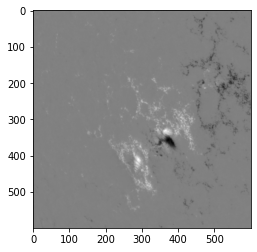

In [24]:
#just double checking that those ^ look right after the conversion
test=glob.glob('/mnt/zena/tiff/hmi/*/*.tiff')[0]
print(test)

t=Image.open(test)
t=np.array(t)
plt.imshow(t, cmap='gray')